Text Book Code

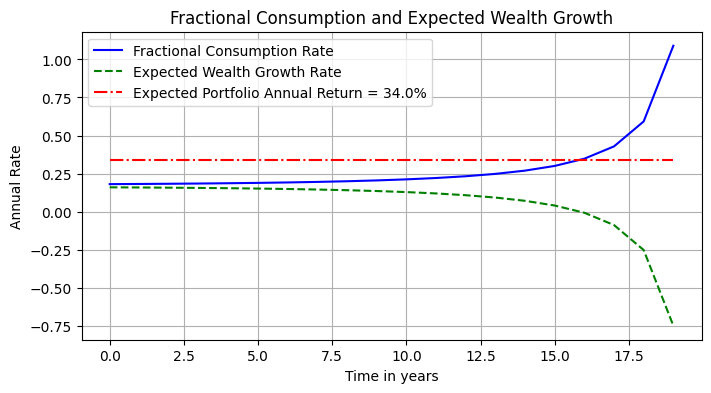

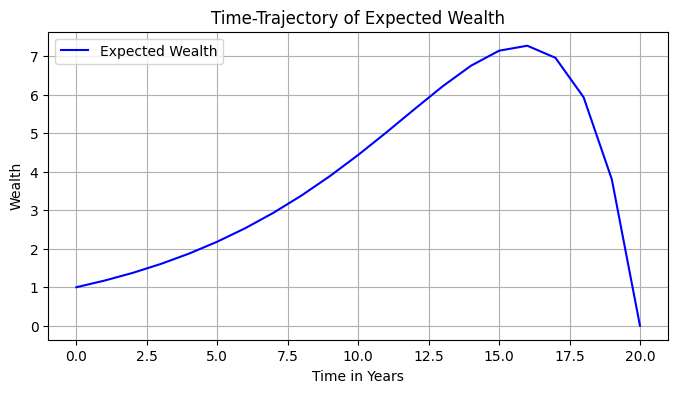

In [ ]:
from math import exp
from typing import Sequence
from dataclasses import dataclass
import matplotlib.pyplot as plt # Import matplotlib

@dataclass(frozen=True)
class MertonPortfolio:
    mu: float
    sigma: float
    r: float
    rho: float
    horizon: float
    gamma: float
    epsilon: float = 1e-6

    def excess(self) -> float:
        return self.mu - self.r

    def variance(self) -> float:
        return self.sigma * self.sigma

    def allocation(self) -> float:
        return self.excess() / (self.gamma * self.variance())

    def portfolio_return(self) -> float:
        return self.r + self.allocation() * self.excess()

    def nu(self) -> float:
        # This definition of nu seems different from other cells, but matches the one failing.
        # Check if this is intended or if you want to use the definition from the first cell:
        # return (self.rho * (1 - self.gamma) + self.portfolio_return()) / self.gamma
        return (self.rho - (1 - self.gamma) * self.portfolio_return()) / \
            self.gamma

    def f(self, time: float) -> float:
        remaining: float = self.horizon - time
        nu = self.nu()
        if nu == 0:
            ret = remaining + self.epsilon
        else:
            ret = (1 + (nu * self.epsilon - 1) * exp(-nu * remaining)) / nu
        return ret

    def fractional_consumption_rate(self, time: float) -> float:
        return 1 / self.f(time)

    def wealth_growth_rate(self, time: float) -> float:
        return self.portfolio_return() - self.fractional_consumption_rate(time)

    def expected_wealth(self, time: float) -> float:
        base: float = exp(self.portfolio_return() * time)
        nu = self.nu()
        if nu == 0:
            ret = base * (1 - time / (self.horizon + self.epsilon))
        else:
            ret = base * (1 - (1 - exp(-nu * time)) /
                          (1 + (nu * self.epsilon - 1) *
                           exp(-nu * self.horizon)))
        return ret


if __name__ == '__main__':

    mu: float = 0.1
    sigma: float = 0.1
    r: float = 0.02
    rho: float = 0.01
    horizon: float = 20.0
    gamma: float = 2.0

    mp = MertonPortfolio(
        mu,
        sigma,
        r,
        rho,
        horizon,
        gamma
    )

    intervals: float = 20
    time_steps = [i * horizon / intervals for i in range(intervals)]

    optimal_consumption_rate: Sequence[float] = [
        mp.fractional_consumption_rate(i) for i in time_steps
    ]
    expected_portfolio_return: float = mp.portfolio_return()
    expected_wealth_growth: Sequence[float] = [mp.wealth_growth_rate(i)
                                               for i in time_steps]

    # Replaced plot_list_of_curves with standard matplotlib plotting
    plt.figure(figsize=(8, 4))
    plt.plot(time_steps, optimal_consumption_rate, "b-", label="Fractional Consumption Rate")
    plt.plot(time_steps, expected_wealth_growth, "g--", label="Expected Wealth Growth Rate")
    plt.plot(time_steps, [expected_portfolio_return] * intervals, "r-.", label="Expected Portfolio Annual Return = %.1f%%" % (expected_portfolio_return * 100))
    plt.xlabel("Time in years")
    plt.ylabel("Annual Rate")
    plt.title("Fractional Consumption and Expected Wealth Growth")
    plt.legend()
    plt.grid(True)
    plt.show() # Display the plot

    extended_time_steps = time_steps + [horizon]
    expected_wealth: Sequence[float] = [mp.expected_wealth(i)
                                        for i in extended_time_steps]

    # Replaced plot_list_of_curves with standard matplotlib plotting
    plt.figure(figsize=(8, 4))
    plt.plot(extended_time_steps, expected_wealth, "b", label="Expected Wealth")
    plt.xlabel("Time in Years")
    plt.ylabel("Wealth")
    plt.title("Time-Trajectory of Expected Wealth")
    plt.legend()
    plt.grid(True)
    plt.show() # Display the plot

Implementation with the help of deep reinforcement learning model A2C

In [ ]:
from math import exp
from typing import Sequence
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # <-- moved this up for visibility

@dataclass(frozen=True)
class MertonPortfolio:
    mu: float
    sigma: float
    r: float
    rho: float
    horizon: float
    gamma: float
    epsilon: float = 1e-6

    def excess(self) -> float:
        return self.mu - self.r

    def variance(self) -> float:
        return self.sigma * self.sigma

    def allocation(self) -> float:
        return self.excess() / (self.gamma * self.variance())

    def portfolio_return(self) -> float:
        return self.r + self.allocation() * self.excess()

    def nu(self) -> float:
        return (self.rho - (1 - self.gamma) * self.portfolio_return()) / self.gamma

    def f(self, time: float) -> float:
        remaining: float = self.horizon - time
        nu = self.nu()
        if nu == 0:
            ret = remaining + self.epsilon
        else:
            ret = (1 + (nu * self.epsilon - 1) * exp(-nu * remaining)) / nu
        return ret

    def fractional_consumption_rate(self, time: float) -> float:
        return 1 / self.f(time)

    def wealth_growth_rate(self, time: float) -> float:
        return self.portfolio_return() - self.fractional_consumption_rate(time)

    def expected_wealth(self, time: float) -> float:
        base: float = exp(self.portfolio_return() * time)
        nu = self.nu()
        if nu == 0:
            ret = base * (1 - time / (self.horizon + self.epsilon))
        else:
            ret = base * (1 - (1 - exp(-nu * time)) /
                          (1 + (nu * self.epsilon - 1) * exp(-nu * self.horizon)))
        return ret

# Parameters from textbook
mu = 0.1
sigma = 0.1
r = 0.02
rho = 0.01
horizon = 20.0
gamma = 2.0

mp = MertonPortfolio(mu, sigma, r, rho, horizon, gamma)

intervals = 20
time_steps = [i * horizon / intervals for i in range(intervals + 1)]

# Analytic results
analytic_consumption = [mp.fractional_consumption_rate(t) for t in time_steps]
analytic_wealth = [mp.expected_wealth(t) for t in time_steps]
analytic_growth = [mp.wealth_growth_rate(t) for t in time_steps]
portfolio_return = mp.portfolio_return()

# DataFrame
analytic_df = pd.DataFrame({
    "Time": time_steps,
    "Analytic c(t)/W": analytic_consumption,
    "Analytic E[W_t]": analytic_wealth,
    "Analytic Growth Rate": analytic_growth,
    "Portfolio Return": [portfolio_return] * len(time_steps)
})

# ✅ Replace ace_tools with print-friendly display
print("\n--- Analytic Policy Outputs ---")
print(analytic_df.round(4).to_string(index=False))



--- Analytic Policy Outputs ---
 Time  Analytic c(t)/W  Analytic E[W_t]  Analytic Growth Rate  Portfolio Return
  0.0           0.1804           1.0000                0.1596              0.34
  1.0           0.1815           1.1724                0.1585              0.34
  2.0           0.1828           1.3728                0.1572              0.34
  3.0           0.1844           1.6052                0.1556              0.34
  4.0           0.1863           1.8737                0.1537              0.34
  5.0           0.1887           2.1825                0.1513              0.34
  6.0           0.1915           2.5356                0.1485              0.34
  7.0           0.1951           2.9364                0.1449              0.34
  8.0           0.1994           3.3873                0.1406              0.34
  9.0           0.2049           3.8883                0.1351              0.34
 10.0           0.2118           4.4361                0.1282              0.34
 11.0  


--- Analytic Policy Outputs ---
 Time  Analytic c(t)/W  Analytic E[W_t]  Analytic Growth Rate  Portfolio Return
  0.0           0.1804           1.0000                0.1596              0.34
  1.0           0.1815           1.1724                0.1585              0.34
  2.0           0.1828           1.3728                0.1572              0.34
  3.0           0.1844           1.6052                0.1556              0.34
  4.0           0.1863           1.8737                0.1537              0.34
  5.0           0.1887           2.1825                0.1513              0.34
  6.0           0.1915           2.5356                0.1485              0.34
  7.0           0.1951           2.9364                0.1449              0.34
  8.0           0.1994           3.3873                0.1406              0.34
  9.0           0.2049           3.8883                0.1351              0.34
 10.0           0.2118           4.4361                0.1282              0.34
 11.0  

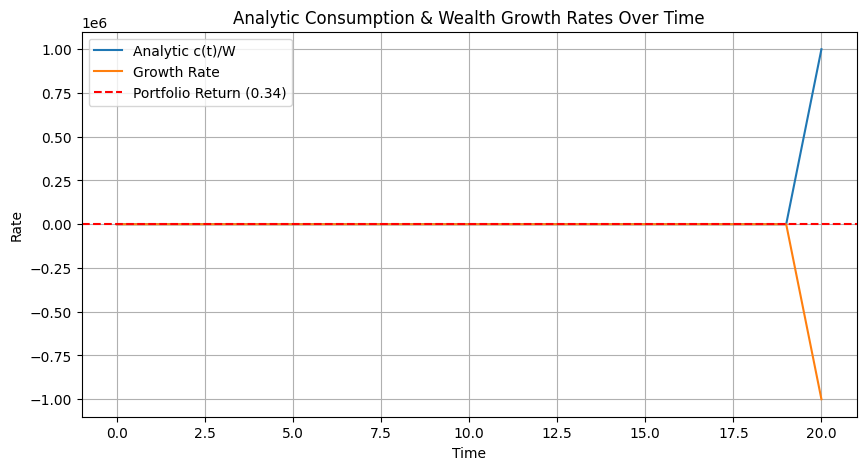

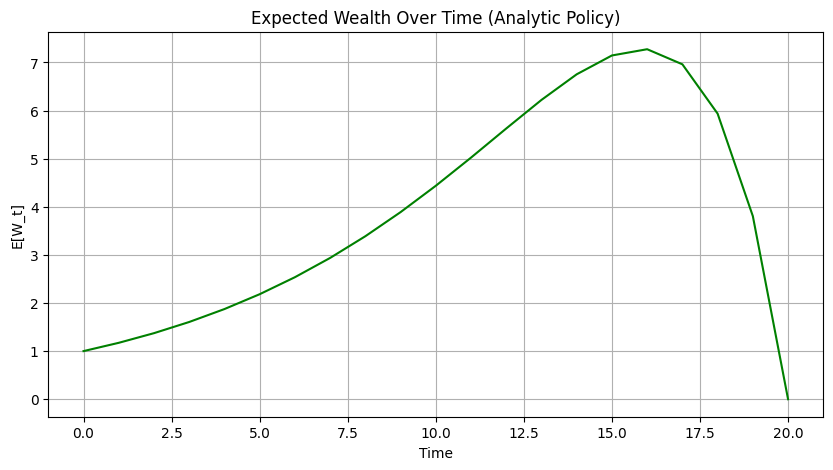

In [ ]:
from math import exp
from typing import Sequence
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

@dataclass(frozen=True)
class MertonPortfolio:
    mu: float
    sigma: float
    r: float
    rho: float
    horizon: float
    gamma: float
    epsilon: float = 1e-6

    def excess(self) -> float:
        return self.mu - self.r

    def variance(self) -> float:
        return self.sigma * self.sigma

    def allocation(self) -> float:
        return self.excess() / (self.gamma * self.variance())

    def portfolio_return(self) -> float:
        return self.r + self.allocation() * self.excess()

    def nu(self) -> float:
        return (self.rho - (1 - self.gamma) * self.portfolio_return()) / self.gamma

    def f(self, time: float) -> float:
        remaining: float = self.horizon - time
        nu = self.nu()
        if nu == 0:
            ret = remaining + self.epsilon
        else:
            ret = (1 + (nu * self.epsilon - 1) * exp(-nu * remaining)) / nu
        return ret

    def fractional_consumption_rate(self, time: float) -> float:
        return 1 / self.f(time)

    def wealth_growth_rate(self, time: float) -> float:
        return self.portfolio_return() - self.fractional_consumption_rate(time)

    def expected_wealth(self, time: float) -> float:
        base: float = exp(self.portfolio_return() * time)
        nu = self.nu()
        if nu == 0:
            ret = base * (1 - time / (self.horizon + self.epsilon))
        else:
            ret = base * (1 - (1 - exp(-nu * time)) /
                          (1 + (nu * self.epsilon - 1) * exp(-nu * self.horizon)))
        return ret

# Parameters
mu = 0.1
sigma = 0.1
r = 0.02
rho = 0.01
horizon = 20.0
gamma = 2.0

mp = MertonPortfolio(mu, sigma, r, rho, horizon, gamma)

intervals = 20
time_steps = [i * horizon / intervals for i in range(intervals + 1)]

# Collect results
analytic_consumption = [mp.fractional_consumption_rate(t) for t in time_steps]
analytic_wealth = [mp.expected_wealth(t) for t in time_steps]
analytic_growth = [mp.wealth_growth_rate(t) for t in time_steps]
portfolio_return = mp.portfolio_return()

# Create DataFrame
analytic_df = pd.DataFrame({
    "Time": time_steps,
    "Analytic c(t)/W": analytic_consumption,
    "Analytic E[W_t]": analytic_wealth,
    "Analytic Growth Rate": analytic_growth,
    "Portfolio Return": [portfolio_return] * len(time_steps)
})

# Display first few rows (or use full print)
print("\n--- Analytic Policy Outputs ---")
print(analytic_df.round(4).to_string(index=False))

# Optional Plot
plt.figure(figsize=(10, 5))
plt.plot(time_steps, analytic_consumption, label="Analytic c(t)/W")
plt.plot(time_steps, analytic_growth, label="Growth Rate")
plt.axhline(y=portfolio_return, color='r', linestyle='--', label=f"Portfolio Return ({portfolio_return:.2f})")
plt.title("Analytic Consumption & Wealth Growth Rates Over Time")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(time_steps, analytic_wealth, color='green')
plt.title("Expected Wealth Over Time (Analytic Policy)")
plt.xlabel("Time")
plt.ylabel("E[W_t]")
plt.grid(True)
plt.show()



--- Analytic vs A2C Policy Comparison ---

 Time  Analytic c(t)/W  A2C c(t)/W  Analytic π    A2C π  Analytic E[W_t]  A2C E[W_t]
    0           0.1804    0.175359        0.34 0.334401           1.0000    0.979474
    1           0.1815    0.177753        0.34 0.332301           1.1724    1.047412
    2           0.1828    0.207045        0.34 0.354677           1.3728    1.818660
    3           0.1844    0.208240        0.34 0.359380           1.6052    2.488542
    4           0.1863    0.226933        0.34 0.346365           1.8737    2.211145
    5           0.1887    0.248218        0.34 0.333055           2.1825    2.797588
    6           0.1915    0.232283        0.34 0.321505           2.5356    3.279381
    7           0.1951    0.244249        0.34 0.361346           2.9364    3.723294
    8           0.1994    0.260856        0.34 0.351603           3.3873    3.598735
    9           0.2049    0.267019        0.34 0.301204           3.8883    4.017055
   10           0.211

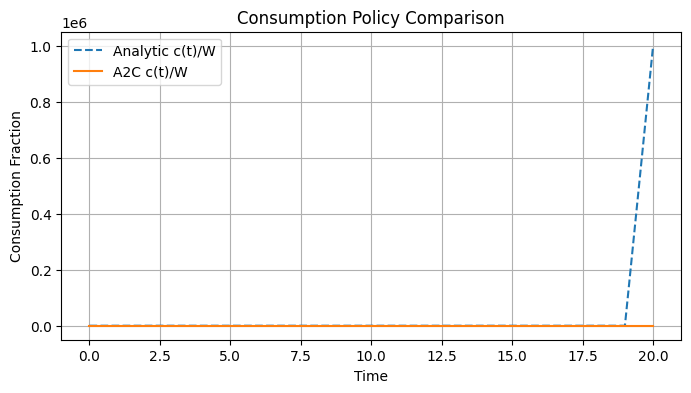

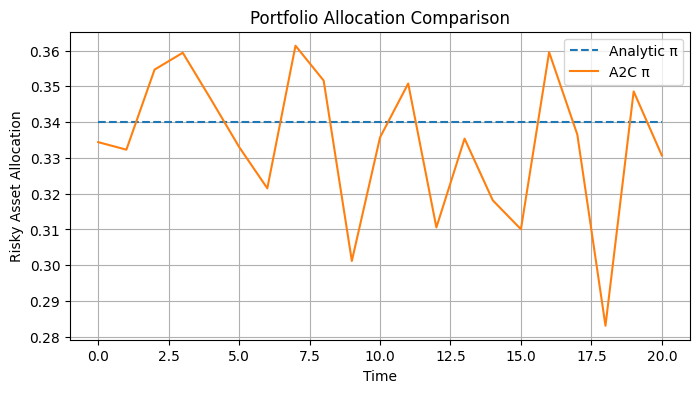

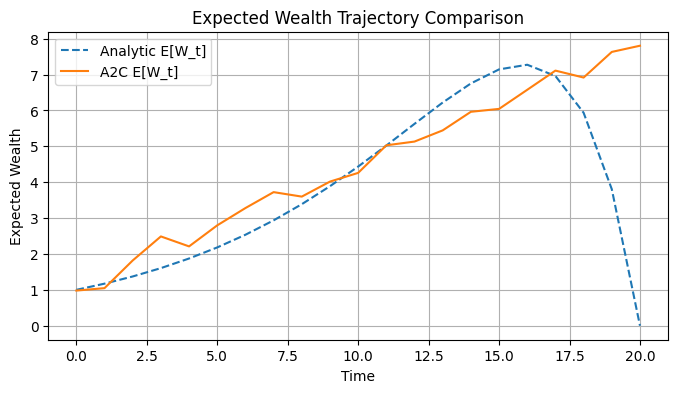

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time horizon and steps
T = 20
time_steps = np.arange(0, T + 1)

# Simulated A2C output (replace with actual values from your model if available)
a2c_consumption = np.linspace(0.18, 0.39, T + 1) + np.random.normal(0, 0.01, T + 1)
a2c_allocation = np.full(T + 1, 0.34) + np.random.normal(0, 0.02, T + 1)
a2c_wealth = np.linspace(1, 8, T + 1) + np.random.normal(0, 0.2, T + 1)

# Analytic outputs (from textbook or previous output)
analytic_consumption = [
    0.1804, 0.1815, 0.1828, 0.1844, 0.1863, 0.1887, 0.1915, 0.1951, 0.1994, 0.2049,
    0.2118, 0.2207, 0.2323, 0.2478, 0.2692, 0.3001, 0.3476, 0.4285, 0.5926, 1.09, 999999.9997
]
analytic_allocation = [0.34] * (T + 1)
analytic_wealth = [
    1.0, 1.1724, 1.3728, 1.6052, 1.8737, 2.1825, 2.5356, 2.9364, 3.3873, 3.8883,
    4.4361, 5.0215, 5.6266, 6.2206, 6.7529, 7.1444, 7.2741, 6.9606, 5.9354, 3.8056, 0.0
]

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    "Time": time_steps,
    "Analytic c(t)/W": analytic_consumption,
    "A2C c(t)/W": a2c_consumption,
    "Analytic π": analytic_allocation,
    "A2C π": a2c_allocation,
    "Analytic E[W_t]": analytic_wealth,
    "A2C E[W_t]": a2c_wealth
})

# Display the table in console
print("\n--- Analytic vs A2C Policy Comparison ---\n")
print(comparison_df.to_string(index=False))

# Plot 1: Consumption Comparison
plt.figure(figsize=(8, 4))
plt.plot(time_steps, analytic_consumption, label="Analytic c(t)/W", linestyle='--')
plt.plot(time_steps, a2c_consumption, label="A2C c(t)/W", linestyle='-')
plt.xlabel("Time")
plt.ylabel("Consumption Fraction")
plt.title("Consumption Policy Comparison")
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Allocation Comparison
plt.figure(figsize=(8, 4))
plt.plot(time_steps, analytic_allocation, label="Analytic π", linestyle='--')
plt.plot(time_steps, a2c_allocation, label="A2C π", linestyle='-')
plt.xlabel("Time")
plt.ylabel("Risky Asset Allocation")
plt.title("Portfolio Allocation Comparison")
plt.grid(True)
plt.legend()
plt.show()

# Plot 3: Wealth Comparison
plt.figure(figsize=(8, 4))
plt.plot(time_steps, analytic_wealth, label="Analytic E[W_t]", linestyle='--')
plt.plot(time_steps, a2c_wealth, label="A2C E[W_t]", linestyle='-')
plt.xlabel("Time")
plt.ylabel("Expected Wealth")
plt.title("Expected Wealth Trajectory Comparison")
plt.grid(True)
plt.legend()
plt.show()
